<a href="https://colab.research.google.com/github/abhinavsagar/Breast-cancer-classification/blob/master/Breast_cancer_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading & Preprocessing

In [87]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


%matplotlib inline

In [88]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".tif":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

Benign_train = np.array(Dataset_loader('ICIAR_Dataset/train/benign',224))
Malign_train = np.array(Dataset_loader('ICIAR_Dataset/train/malignant',224))
Benign_test = np.array(Dataset_loader('ICIAR_Dataset/test/benign',224))
Malign_test = np.array(Dataset_loader('ICIAR_Dataset/test/malignant',224))

100%|██████████| 23/23 [00:01<00:00, 12.23it/s]


In [164]:
benign_train_augmented = []
malign_train_augmented = []
benign_test_augmented = []
malign_test_augmented = []

In [165]:
for image in benign_train:
    im90 = np.rot90(image)
    im180 = np.rot90(im90)
    im270 = np.rot90(im180)
    benign_train_augmented.append(im90)
    benign_train_augmented.append(im180)
    benign_train_augmented.append(im270)
benign_train = np.insert(benign_train,len(benign_train),benign_train_augmented,axis=0)

for image in malign_train:
    im90 = np.rot90(image)
    im180 = np.rot90(im90)
    im270 = np.rot90(im180)
    malign_train_augmented.append(im90)
    malign_train_augmented.append(im180)
    malign_train_augmented.append(im270)
malign_train = np.insert(malign_train,len(malign_train),malign_train_augmented,axis=0)

for image in benign_test:
    im90 = np.rot90(image)
    im180 = np.rot90(im90)
    im270 = np.rot90(im180)
    benign_test_augmented.append(im90)
    benign_test_augmented.append(im180)
    benign_test_augmented.append(im270)
benign_test = np.insert(benign_test,len(benign_test),benign_test_augmented,axis=0)

for image in malign_test:
    im90 = np.rot90(image)
    im180 = np.rot90(im90)
    im270 = np.rot90(im180)
    malign_test_augmented.append(im90)
    malign_test_augmented.append(im180)
    malign_test_augmented.append(im270)
malign_test = np.insert(malign_test,len(malign_test),malign_test_augmented,axis=0)

In [168]:
print(len(benign_train))
print(len(malign_train))
print(len(benign_test))
print(len(malign_test))

652
712
148
88


In [170]:
np.random.shuffle(benign_train)
np.random.shuffle(malign_train)
np.random.shuffle(benign_test)
np.random.shuffle(malign_test)

# Create Label

In [193]:
# Skin Cancer: Malignant vs. Benign
# Create labels
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

# Merge data 
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

# Train and Evalutation split

In [189]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

# Display Some Images

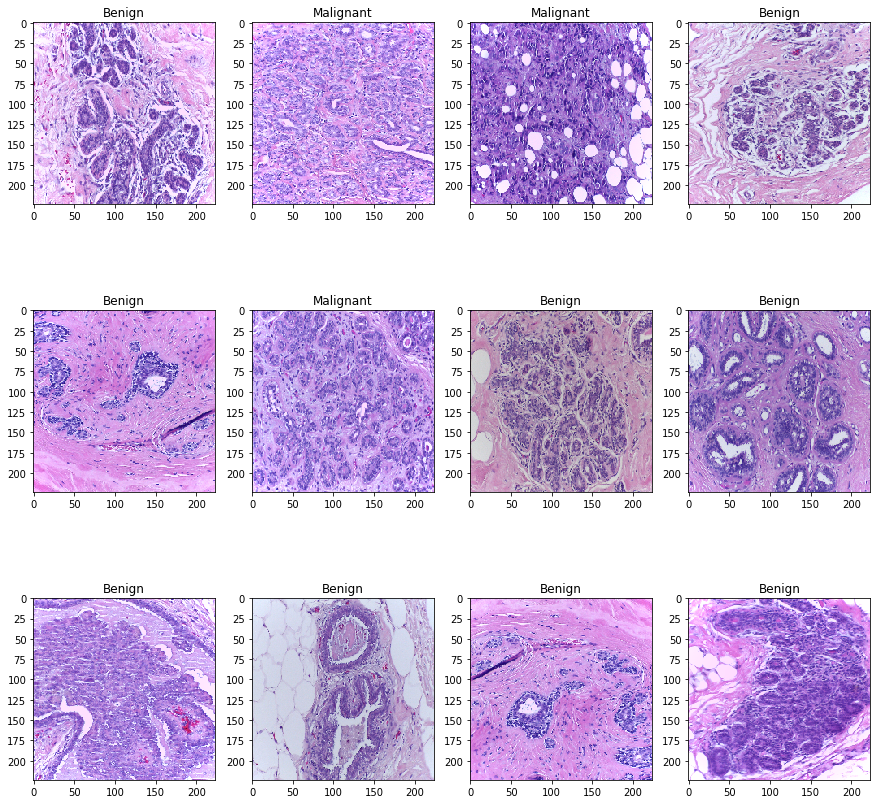

In [176]:

# # Display first 15 images of moles, and how they are classified
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

# Data Generator

In [177]:
BATCH_SIZE = 16

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

# Model: ResNet50

In [178]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

In [179]:
K.clear_session()
gc.collect()

resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)


 


model = build_model(resnet ,lr = 1e-4)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1920)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1920)              7680      
_________________________________________________________________
dense (Dense)                (None, 2)                 3842      
Total params: 18,333,506
Trainable params: 18,100,610
Non-trainable params: 232,896
_________________________________________________________________


In [180]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# Training & Evaluation

In [181]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

/Users/rishab/Library/Python/3.8/lib/python/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
68/68 [==============================] - 953s 14s/step - loss: 0.6883 - accuracy: 0.6204 - val_loss: 0.4038 - val_accuracy: 0.8095
Epoch 2/20
68/68 [==============================] - 960s 14s/step - loss: 0.5164 - accuracy: 0.7472 - val_loss: 0.7409 - val_accuracy: 0.7363
Epoch 3/20
68/68 [==============================] - 990s 15s/step - loss: 0.4333 - accuracy: 0.8221 - val_loss: 0.1556 - val_accuracy: 0.9560
Epoch 4/20
68/68 [==============================] - 947s 14s/step - loss: 0.3908 - accuracy: 0.8466 - val_loss: 0.1813 - val_accuracy: 0.9304
Epoch 5/20
68/68 [==============================] - 979s 14s/step - loss: 0.3308 - accuracy: 0.8605 - val_loss: 0.2465 - val_accuracy: 0.9267
Epoch 6/20
68/68 [==============================] - 963s 14s/step - loss: 0.3213 - accuracy: 0.8747 - val_loss: 0.4986 - val_accuracy: 0.8498
Epoch 7/20
68/68 [==============================] - 995s 15s/step - loss: 0.2615 - accuracy: 0.9044 - val_loss: 0.2390 - val_accuracy: 0.9194
Epoch 

In [182]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

<AxesSubplot:>

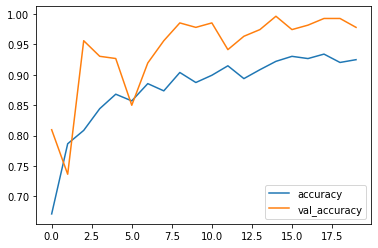

In [183]:
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

<AxesSubplot:>

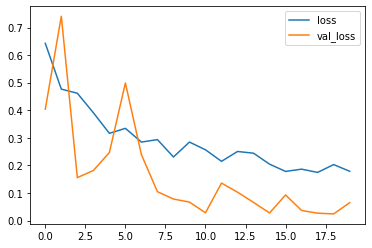

In [184]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

# Prediction

In [194]:
Y_pred = model.predict(X_test)

In [195]:
accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

0.885593220338983

### Confusion Matrix

Confusion matrix, without normalization
[[130  18]
 [  9  79]]


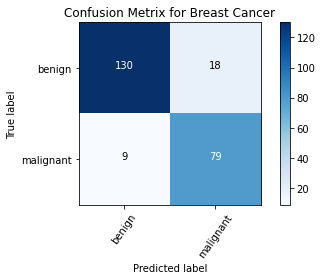

In [196]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Breast Cancer')

In [34]:
model.save_weights("weights_ICIAR.best.hdf5")